In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.9 MB/s 


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
import tensorflow_addons as tfa

from keras import backend as K

In [4]:
# Colab loading
mask_data = np.load("drive/MyDrive/Colab Notebooks/COMP3710/mask_data.npy")
input_data = np.load("drive/MyDrive/Colab Notebooks/COMP3710/input_data.npy")

IMAGE_HEIGHT = 256
IMAGE_WEIGHT = 192

In [5]:
mask_data = np.expand_dims(mask_data, axis=3)
input_data = np.expand_dims(input_data, axis=3)

# Normalization
mask_data = mask_data / 255.0
input_data = input_data / 255.0

In [6]:
print(mask_data.shape)
print(input_data.shape)

(2594, 256, 192, 1)
(2594, 256, 192, 1)


In [7]:
# Split the data 
X_train, X_test, Y_train, Y_test = train_test_split(input_data, mask_data, test_size = 0.2, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)

In [8]:
# To tf dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

In [9]:
train_data = train_data.shuffle(len(train_data))
test_data = test_data.shuffle(len(test_data))
val_data = val_data.shuffle(len(val_data))

In [10]:
def display_image(data,num):
  plt.figure(figsize=(10,3*num))
  i = 1
  for X,Y in data.take(num):
    plt.subplot(num, 2, i)
    plt.imshow(tf.reshape(X,[IMAGE_HEIGHT,IMAGE_WEIGHT]), cmap='gray')
    plt.axis('off')
    i += 1
    plt.subplot(num, 2, i)
    # plt.imshow(Y, cmap='gray')
    plt.imshow(tf.reshape(Y,[IMAGE_HEIGHT,IMAGE_WEIGHT]), cmap='gray')
    plt.axis('off')
    i += 1
  plt.show()

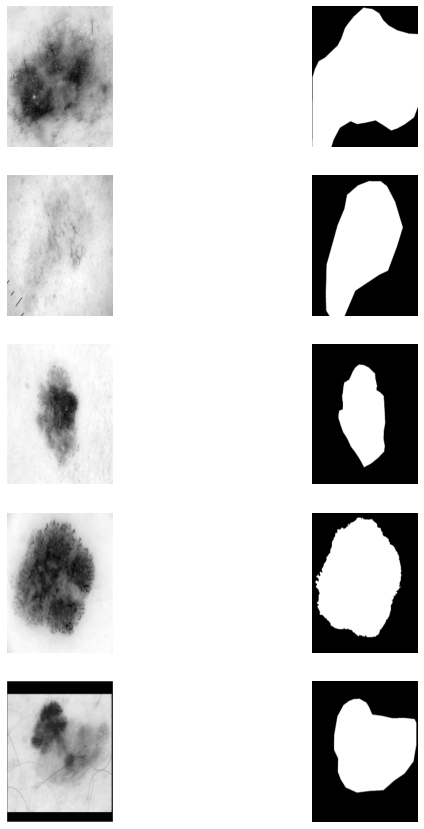

In [11]:
display_image(train_data,5)

In [12]:
def get_improved_unet(input_shape):
  def context_module(input,size):
    """
    context module is pre-activation residual block with two
      3x3x3 convolutional layers and a dropout layer (pdrop = 0.3) in between.
    """
    out = tfa.layers.InstanceNormalization()(input)
    out = Conv2D(size,3 , activation = LeakyReLU(alpha=0.01), padding = 'same')(out)

    out = Dropout(0.3)(out)

    out = tfa.layers.InstanceNormalization()(out)
    out = Conv2D(size, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(out)
    return out
  
  def segmentation_layer(layer):
    return tf.keras.layers.Conv2D(1, (1,1), activation = 'sigmoid')(layer)
  
  inputs = Input(input_shape)

  conv1_1 = Conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(inputs)
  conv1_2 = context_module(conv1_1,16)
  add1 = Add()([conv1_1,conv1_2])
  
  # pool1 = MaxPooling2D(pool_size = (2, 2))(merg1)
  
  conv2_1 = Conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same', strides = 2)(add1)
  conv2_2 = context_module(conv2_1,32)
  add2 = Add()([conv2_1,conv2_2])
  # (None, 128, 96, 32)

  conv3_1 = Conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same', strides = 2)(add2)
  conv3_2 = context_module(conv3_1,64)
  add3 = Add()([conv3_1,conv3_2])

  conv4_1 = Conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding = 'same', strides = 2)(add3)
  conv4_2 = context_module(conv4_1,128)
  add4 = Add()([conv4_1,conv4_2])

  conv5_1 = Conv2D(256, 3, activation = LeakyReLU(alpha=0.01), padding = 'same', strides = 2)(add4)
  conv5_2 = context_module(conv5_1,256)
  add5 = Add()([conv5_1,conv5_2])
  # (None, 16, 12, 256)

  up1 = Conv2D(128, 2, activation = LeakyReLU(alpha=0.01), padding = 'same')(UpSampling2D(size = (2, 2))(add5))
  
  merge1 = concatenate([add4, up1])
  up_conv1 = tf.keras.layers.Conv2D(128, 3, activation = LeakyReLU(alpha=0.01), padding ='same')(merge1)
  up_conv1 = tf.keras.layers.Conv2D(128, 1, activation = LeakyReLU(alpha=0.01), padding ='same')(up_conv1)

  up2 = Conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(UpSampling2D(size = (2, 2))(up_conv1))
  merge2 = concatenate([add3, up2])
  up_conv2 = tf.keras.layers.Conv2D(64, 3, activation = LeakyReLU(alpha=0.01), padding ='same')(merge2)
  up_conv2 = tf.keras.layers.Conv2D(64, 1, activation = LeakyReLU(alpha=0.01), padding ='same')(up_conv2)

  up3 = Conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(UpSampling2D(size = (2, 2))(up_conv2))
  merge3 = concatenate([add2, up3])
  up_conv3 = tf.keras.layers.Conv2D(32, 3, activation = LeakyReLU(alpha=0.01), padding ='same')(merge3)
  up_conv3 = tf.keras.layers.Conv2D(32, 1, activation = LeakyReLU(alpha=0.01), padding ='same')(up_conv3)

  up4 = Conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding = 'same')(UpSampling2D(size = (2, 2))(up_conv3))
  merge4 = concatenate([add1, up4])
  up_conv4 = tf.keras.layers.Conv2D(16, 3, activation = LeakyReLU(alpha=0.01), padding ='same')(merge4)

  seg1 = segmentation_layer(up_conv2)
  seg2 = segmentation_layer(up_conv3)
  
  add_seg1 = Add()([UpSampling2D(size = (2, 2))(seg1),seg2])

  seg4 = segmentation_layer(up_conv4)
  add_seg2 = Add()([UpSampling2D(size = (2, 2))(add_seg1),seg4])

  output = Conv2D(1, 1, activation = 'sigmoid')(add_seg2)

  model = Model(inputs = inputs, outputs = output)

  return model

In [13]:
model = get_improved_unet(input_shape = (IMAGE_HEIGHT, IMAGE_WEIGHT, 1))

In [14]:
def dice_coef_loss(y_true, y_pred):
  '''
  Dice loss to minimize. Pass to model as loss during compile statement
  '''
  return 1 - dice_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=0):
  """
  function to calculate dice similarity
  """
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
# model.compile(optimizer = 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics = [dice_coef])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [dice_coef])
# model.compile(optimizer = 'adam', loss = dice_coef_loss, metrics = ["accuracy",dice_coef])
history = model.fit(train_data.batch(10), epochs = 40, validation_data = val_data.batch(10))


Epoch 1/40
166/166 [==============================] - 90s 324ms/step - loss: 0.3186 - dice_coef: 0.4540 - val_loss: 0.2774 - val_dice_coef: 0.4976
Epoch 2/40
166/166 [==============================] - 52s 312ms/step - loss: 0.2712 - dice_coef: 0.5166 - val_loss: 0.2612 - val_dice_coef: 0.5269
Epoch 3/40
166/166 [==============================] - 52s 311ms/step - loss: 0.2468 - dice_coef: 0.5479 - val_loss: 0.2336 - val_dice_coef: 0.5659
Epoch 4/40
166/166 [==============================] - 52s 311ms/step - loss: 0.2360 - dice_coef: 0.5732 - val_loss: 0.2263 - val_dice_coef: 0.5869
Epoch 5/40
166/166 [==============================] - 52s 311ms/step - loss: 0.2202 - dice_coef: 0.5961 - val_loss: 0.2065 - val_dice_coef: 0.6171
Epoch 6/40
166/166 [==============================] - 51s 310ms/step - loss: 0.2059 - dice_coef: 0.6215 - val_loss: 0.1947 - val_dice_coef: 0.6413
Epoch 7/40
166/166 [==============================] - 52s 311ms/step - loss: 0.1937 - dice_coef: 0.6447 - val_loss: 0.

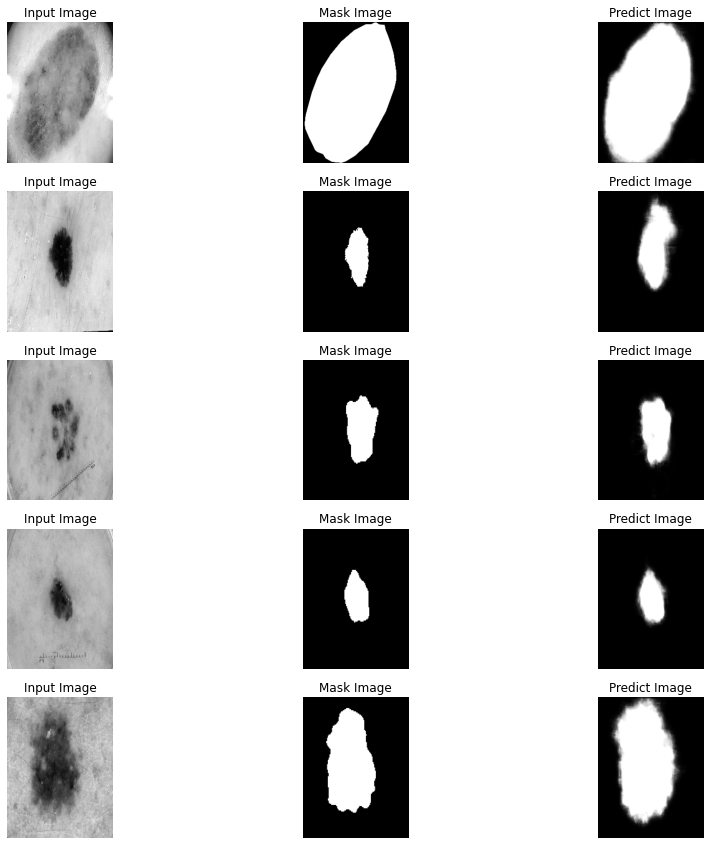

In [16]:
def display_prediction(num):
  i = 1
  plt.figure(figsize=(15,3*num))
  for t_x,t_y in test_data.take(num):
    y_predict = model.predict(t_x[tf.newaxis, ...])
    ax = plt.subplot(num, 3, i)
    ax.set_title("Input Image")
    plt.imshow(tf.reshape(t_x,[IMAGE_HEIGHT,IMAGE_WEIGHT]), cmap='gray')
    plt.axis('off')
    i += 1
    ax = plt.subplot(num, 3, i)
    ax.set_title("Mask Image")
    plt.imshow(tf.reshape(t_y,[IMAGE_HEIGHT,IMAGE_WEIGHT]), cmap='gray')
    plt.axis('off')
    i += 1
    ax = plt.subplot(num, 3, i)
    ax.set_title("Predict Image")
    plt.imshow(tf.reshape(y_predict,[IMAGE_HEIGHT,IMAGE_WEIGHT]), cmap='gray')
    plt.axis('off')
    i += 1
  
  plt.show()

display_prediction(5)

In [17]:
y_pred = model.predict(X_test)

In [18]:
def numpy_dice_coef(y_true, y_pred,smooth = 1e-5):
  """
  function to calculate dice similarity by numpy
  """
  y_true_f = y_true.flatten()
  y_pred_f = y_pred.flatten()
  intersection = np.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [19]:
test_dice_coef = []
for pre,test in zip(y_pred,Y_test):
  test_dice_coef.append(numpy_dice_coef(pre,test))

print(np.mean(test_dice_coef))

0.8124086485138939


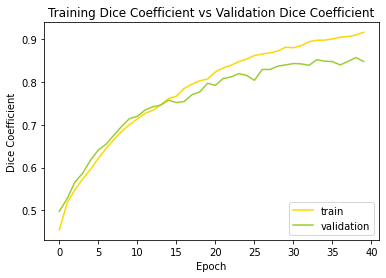

In [20]:
def plot_similarity():
  """
  Plot the dice similarity score
  """
  plt.figure(1)
  plt.plot(history.history['dice_coef'],'gold', label='train')
  plt.plot(history.history['val_dice_coef'],'yellowgreen', label='validation')
  plt.xlabel("Epoch")
  plt.ylabel("Dice Coefficient")
  plt.legend(loc='lower right')
  plt.title("Training Dice Coefficient vs Validation Dice Coefficient")
  plt.show()

plot_similarity()